# ISPR 2025 - Midterm 3 - Assignament 2 - Gianluca Panzani (550358)

In [374]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F
from torchvision import transforms

## Dataset class definition

Here is defined the Dataset class, which allows to iterate easily on the batches of the dataset, and some utility methods.

The size of the images has been standardized to 128x128 and the mean and the standard deviation of the images are computed to normalize them during the loading.

In [375]:
def get_img(img_dir: str, prefix: str, index: int, postfix: str, mask=False) -> Image:
    '''
    Get the image from the directory. The name of the image is composed as follows: "<img_dir><prefix>[<zeros>]<index><postfix>".
    The number of zeros is determined by the index.
    
    Parameters:
    - img_dir (str): directory where the images are stored.
    - prefix (str): prefix of the image name.
    - index (int): index of the image.
    - postfix (str): postfix of the image name.
    - mask (bool): is True if the image is a mask, False if the image is a normal image.

    Returns: the image as a PIL Image object.
    '''
    zeros = '00' if index < 10 else '0' if index < 100 else ''
    full_path = f'{img_dir}{prefix}{zeros}{index}{postfix}'
    if not mask:
        return Image.open(full_path).convert('RGB')
    return Image.open(full_path).convert('L')

def from_img_to_tensor(img: Image, resize_shape: tuple, mean=None, std=None) -> torch.Tensor:
    '''
    Convert the image to a tensor. Are applied normalization, if mean and std are provided, and resize.
    
    Parameters:
    - img (PIL.Image): image to be converted.
    - resize_shape (tuple): shape to resize the image to.
    - mean (list): mean values for normalization.
    - std (list): std values for normalization.

    Returns: the image as a tensor.
    '''
    if mean is not None and std is not None:
        if not (len(mean) == 3 and len(std) == 3):
            raise ValueError('The image has 3 channles. The parameters "mean" and "std" have to be lists with length equal to 3.')
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor(), # Scaling
            transforms.Normalize(mean, std) # Normalization
        ])
    else:
        transform = transforms.Compose([
            transforms.Resize(resize_shape), # Resize
            transforms.ToTensor() # Scaling
        ])
    return transform(img)
    
def from_mask_to_tensor(img: Image, resize_shape: tuple) -> torch.Tensor:
    '''
    Convert the mask to a tensor and resize is applied.
    
    Parameters:
    - img (PIL.Image): image to be converted.
    - resize_shape (tuple): shape to resize the image to.
    
    Returns: the image as a tensor.
    '''
    img = img.resize(resize_shape, resample=Image.NEAREST)
    img_np = np.array(img)
    if img_np.max() > 1:
        img_np = (img_np > 127).astype(np.uint8)
    tensor = torch.from_numpy(img_np).float().unsqueeze(0)  # shape: [1, H, W]
    return tensor

def get_mean_and_std(images_dir: str, img_prefix: str, img_postfix: str, resize_shape: tuple):
    '''
    Compute the mean and the standard deviation of all the images in the directory. The name of the image is composed as follows:
    "<img_dir><prefix>[<zeros>]<index><postfix>". The number of zeros is determined by the index, which is incremented until the image is not found.
    
    Parameters:
    - images_dir (str): directory where the images are stored.
    - img_prefix (str): prefix of the image name.
    - img_postfix (str): postfix of the image name.
    - resize_shape (tuple): shape to resize the image to.
    
    Returns:
    - mean (list): the mean of the images.
    - std (list): the standard deviation of the images.
    '''
    mean = torch.zeros(3)
    std = torch.zeros(3)
    i = 0
    while True:
        i += 1
        try:
            image = get_img(img_dir=images_dir, prefix=img_prefix, index=i, postfix=img_postfix, mask=False)
        except:
            break
        img = from_img_to_tensor(img=image, resize_shape=resize_shape)
        mean += img.mean(dim=(1, 2)) # Mean computed on each channel (e.g. with RGB -> [meanR,meanG,meanB])
        std += img.std(dim=(1, 2)) # Std computed on each channel (e.g. with RGB -> [stdR,stdG,stdB])
    mean = (mean / (i-1)).tolist()
    std = (std / (i-1)).tolist()
    return mean, std



class HorseSegmentationDataset(Dataset):
    def __init__(self, images_dir, img_prefix, img_postfix, masks_dir, mask_prefix, mask_postfix, resize_shape=(128,128)):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.img_prefix = img_prefix
        self.mask_prefix = mask_prefix
        self.img_postfix = img_postfix
        self.mask_postfix = mask_postfix
        self.resize_shape = resize_shape
        self.length = len(os.listdir(images_dir))
        mean, std = get_mean_and_std(
            images_dir=self.images_dir,
            img_prefix=self.img_prefix,
            img_postfix=self.img_postfix,
            resize_shape=self.resize_shape
        )
        self.mean = mean
        self.std = std

    def __getitem__(self, index):
        img = get_img(self.images_dir, self.img_prefix, index+1, self.img_postfix, mask=False)
        mask = get_img(self.masks_dir, self.mask_prefix, index+1, self.mask_postfix, mask=True)
        img_tensor = from_img_to_tensor(img, self.resize_shape, self.mean, self.std)
        mask_tensor = from_mask_to_tensor(mask, self.resize_shape)
        return img_tensor, mask_tensor
    
    def __len__(self):
        return self.length



# Creation of the dataset object
horse_dataset = HorseSegmentationDataset(
    images_dir='weizmann_horse_db/horse/',
    img_prefix='horse',
    img_postfix='.png',
    masks_dir='weizmann_horse_db/mask/',
    mask_prefix='horse',
    mask_postfix='.png',
    resize_shape=(128,128)
)

## Model class

In the following block, are implemented 2 classes: the ConvolutionalAE, and the UNet.

Initially i had created the CAE architecture, but i have seen that results wasn't satisfiable and find better parameters was hard. In fact, with this architecture, i reached at most ~77% of accuracy. This is why i decided to implement a UNet too, which performed fastly better than the CAE. Both the implementations are dynamic, so that allowed me to use a Grid search to find the best combination of hyperparameters (which is described below).

To be more precise, i cited the CAE architecture for completeness in the explanation of my reasoning, but it's not used in the following code. The model selection is performed with the only use of the UNet class, just because the performances are considerably better (with respect to the ConvolutionalAE architecture).


## Architecture

The implemented architecture is a U-Net-based convolutional neural network designed for semantic segmentation. It consists of an encoder–decoder structure with skip connections.

The encoder is composed of a sequence of convolutional blocks, each followed by a downsampling operation via max pooling (in the forward pass). At the bottom of the U, there is the bottleneck block which doubles the number of channels. The decoder mirrors the encoder in reverse order: each stage begins with a transposed convolution for upsampling, followed by a convolutional block that reduces the number of channels. The final layer is a 1×1 convolution to map the features to a single-channel output with sigmoid activation function.

Skip connections are used to concatenate encoder features with decoder inputs at each corresponding resolution level.

In [376]:
class ConvolutionalAE(nn.Module):
    def __init__(self, encoder_channels: list[int], decoder_channels: list[int], encoder_kernel_sizes: list[int], decoder_kernel_sizes: list[int],
                 encoder_strides: list[int], decoder_strides: list[int], output_padding: int):
        super(ConvolutionalAE, self).__init__()
        # Encoder architecture
        layers = []
        for i in range(len(encoder_channels)-1):
            k = encoder_kernel_sizes[i]
            s = encoder_strides[i]
            layers.append(nn.Conv2d(encoder_channels[i], encoder_channels[i+1], kernel_size=k, stride=s, padding=k//2))
            layers.append(nn.ReLU())
        self.encoder = nn.Sequential(*layers)
        # Decoder architecture
        layers = []
        for i in range(len(decoder_channels)-2):
            k = decoder_kernel_sizes[i]
            s = decoder_strides[i]
            layers.append(nn.ConvTranspose2d(decoder_channels[i], decoder_channels[i+1], kernel_size=k, stride=s, padding=k//2, output_padding=output_padding))
            layers.append(nn.ReLU())
        layers.append(nn.ConvTranspose2d(decoder_channels[-2], decoder_channels[-1], kernel_size=decoder_kernel_sizes[-1], stride=decoder_strides[-1]))
        layers.append(nn.Sigmoid())
        self.decoder = nn.Sequential(*layers)

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        x = F.interpolate(x, size=(128, 128), mode='bilinear', align_corners=False)
        return x
    



class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[32, 64, 128], kernel_size=3, activation='relu'):
        super(UNet, self).__init__()
        # Initializations
        self.kernel_size = kernel_size
        self.activation = activation
        self.encoders = nn.ModuleList()
        self.decoders = nn.ModuleList()
        # Encoder
        for feature in features:
            self.encoders.append(self._convolutional_block(in_channels, feature))
            in_channels = feature
        # Bottleneck
        self.bottleneck = self._convolutional_block(features[-1], 2*features[-1])
        # Decoder
        in_channels = 2*features[-1]
        for feature in features[::-1]: # Scans the list reversed (step=-1)
            self.decoders.append(nn.ConvTranspose2d(in_channels, feature, kernel_size=2, stride=2))
            self.decoders.append(self._convolutional_block(2*feature, feature))
            in_channels = feature
        # Final convolution
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        # Encoding
        skip_connections = []
        for encoder in self.encoders:
            x = encoder(x)
            skip_connections.append(x)
            x = F.max_pool2d(x, kernel_size=2, stride=2)
        x = self.bottleneck(x)
        # Decoding
        skip_connections = skip_connections[::-1]
        for i in range(0, len(self.decoders), 2):
            block1_index = i
            block2_index = i+1
            x = self.decoders[block1_index](x) # Transposed Convolutional block
            x_skip = skip_connections[i//2]
            if x.shape != x_skip.shape: # Case of interpolation
                x = F.interpolate(x, size=x_skip.shape[2:])
            x = torch.cat((x_skip, x), dim=1)
            x = self.decoders[block2_index](x) # Convolutional block
        # Final convolution
        x = self.final_conv(x)
        return torch.sigmoid(x)

    def _convolutional_block(self, in_channels, out_channels):
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size=self.kernel_size, padding=self.kernel_size//2),
            self._get_activation(),
            nn.Conv2d(out_channels, out_channels, kernel_size=self.kernel_size, padding=self.kernel_size//2),
            self._get_activation(),
        ]
        return nn.Sequential(*layers)

    def _get_activation(self):
        if self.activation == 'relu':
            return nn.ReLU(inplace=True)
        elif self.activation == 'leaky_relu':
            return nn.LeakyReLU(inplace=True)
        else:
            raise ValueError(f'Unsupported activation: {self.activation}')

## Training method

The training method performs both the training and validation phases. During each epoch, it computes the loss on the training set, the loss on the validation set, and the Intersection over Union (IoU) score.

IoU measures the overlap between the predicted mask and actual mask, and is commonly used as accuracy metric in segmentation tasks.

The early stopping is performed when:
- the mean of the last "k" IoU scores of the current iteration minus the best mean of the last "k" IoU scores is minor than the "threshold" for "tolerance" consecutive epochs.
or:
- the difference between the training loss and the validation loss is higher than 10%.

The condition to increase the counter to reach "tolerance" epochs is:

current_mean_iou_score - best_mean_iou_score < threshold || vl_avg_loss - tr_avg_loss > 0.1

With: current_mean_iou_score = avg(iou_scores[-k:])

In [ ]:
def iou(preds: torch.Tensor, masks: torch.Tensor) -> float:
    '''
    Computes the Intersection over Union (IoU) score between the predicted masks and the actual masks.

    Parameters:
    - preds: the predicted masks (output of the model).
    - masks: the actual masks (ground truth).

    Returns:
    - iou_score: the IoU score.
    '''
    preds = (preds > 0.5).float()
    masks = (masks > 0.5).float()
    # Compute intersection and union
    intersection = (preds * masks).sum()
    union = ((preds + masks) > 0).float().sum()
    # Case of empty union (the predictions and the masks are empty, so equal)
    if union == 0:
        return 1.0
    iou_score = intersection / union
    return iou_score.item()



def train(model: nn.Module, tr_dataloader: DataLoader, vl_dataloader: DataLoader, optimizer, criterion, device, epochs, threshold, tolerance, verbose=1):
    '''
    Performs the training and the validation of the model.

    Parameters:
    - model: the model to train.
    - tr_dataloader: the training set.
    - vl_dataloader: the validation set.
    - optimizer: the optimizer to use.
    - criterion: the loss function to use.
    - device: the device to use (CPU or GPU).
    - epochs: the number of epochs.
    - threshold: the threshold to use for early stopping.
    - tolerance: the number of epochs of tolerance for early stopping.
    - verbose: the verbosity level (0 = no output, 1 = output every epoch).

    Returns:
    - tr_losses: the training losses list.
    - vl_losses: the validation losses list.
    - iou_scores: the IoU scores list.
    '''
    model.to(device)

    # Initializations
    k = 5
    patience = 0
    best_mean_iou_avg_score = 0
    tr_losses = []
    vl_losses = []
    iou_scores = []

    # Iterate on the epochs
    for epoch in range(epochs):

        # Training phase
        model.train()
        total_loss = 0.0
        for imgs, masks in tr_dataloader:
            imgs = imgs.to(device)          # Move images' tensors on GPU or CPU
            masks = masks.to(device)        # Move masks' tensors on GPU or CPU

            preds = model(imgs)             # Compute the predictions
            loss = criterion(preds, masks)  # Compute the loss
            optimizer.zero_grad()           # Reset the gradients
            loss.backward()                 # Perform backpropagation
            optimizer.step()                # Update model's parameters (based on gradients)

            total_loss += loss.item()       # Update total loss with the average loss on this batch

        tr_avg_loss = total_loss / len(tr_dataloader)
        tr_losses.append(tr_avg_loss)

        # Validation phase
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            total_iou = 0.0

            for imgs, masks in vl_dataloader:
                imgs = imgs.to(device)
                masks = masks.to(device)

                preds = model(imgs)
                loss = criterion(preds, masks)

                total_loss += loss.item()
                total_iou += iou(preds, masks)

        vl_avg_loss = total_loss / len(vl_dataloader)
        vl_losses.append(vl_avg_loss)
        iou_avg_score = total_iou / len(vl_dataloader)
        iou_scores.append(iou_avg_score)

        # Print of the epoch result
        if verbose > 0:
            print(f'Epoch {epoch+1}/{epochs}: TR_loss={tr_avg_loss:.4f} - VL_loss={vl_avg_loss:.4f} - IoU={iou_avg_score:.4f}')
        
        # Early stopping (based on IoU score)
        current_mean_iou_avg_score = np.mean(iou_scores[-k:])
        if epoch > k and (current_mean_iou_avg_score - best_mean_iou_avg_score < threshold or vl_avg_loss - tr_avg_loss > 0.1):
            patience += 1
        else:
            patience = 0
        if patience > tolerance:
            if verbose > 0:
                print(f'Early stopping at epoch {epoch+1}')
            break
        if best_mean_iou_avg_score < current_mean_iou_avg_score:
            best_mean_iou_avg_score = current_mean_iou_avg_score
    
    return tr_losses, vl_losses, iou_scores

## Grid search

The hyperparameters on which the Grid search is performed (for UNet architecture) are:
- batch_size
- learning_rate
- epochs
- activation: the activation function to use.
- threshold: the threshold used for the condition of Early stopping.
- tolerance: the number of epochs of tolerence for the Early stopping.
- kernel_size: the dimension of the kernel, which will be a squared matrix of dimension kernel_size.
- features: the number of features in the output for each convolutional block.

For example if features=[32,64,128] means that the decoder will has 3 layers and the number of channels that their outputs have are respectively 32, 64 and 128. The decoder is equal the encoder but reversed, as already described. The rest of the parameters are enough self-explanatory.

In [ ]:
# Space of the hyperparameters for ConvolutionalAE
params_space = { # ignored parameters (not used in the model)
    'batch_size': [16, 32, 64],
    'learning_rate': [0.0001, 0.001],
    'epochs': [75],
    'threshold': [0.0001],
    'tolerance': [10],
    'architecture': [
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,3], 'encoder_strides': [2,2,2],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [3,3,3], 'decoder_strides': [2,2,2],
            'output_padding': 1
        },
        {
            'encoder_channels': [3,32,64], 'encoder_kernel_sizes': [3,3,5], 'encoder_strides': [2,2,1],
            'decoder_channels': [64,32,1], 'decoder_kernel_sizes': [5,3,3], 'decoder_strides': [1,2,2],
            'output_padding': 0
        },
        {
            'encoder_channels': [3,32,64,128], 'encoder_kernel_sizes': [3,3,3,3], 'encoder_strides': [2,2,2,1],
            'decoder_channels': [128,64,32,1], 'decoder_kernel_sizes': [3,3,3,3], 'decoder_strides': [1,2,2,2],
            'output_padding': 0
        },
        {
            'encoder_channels': [3,32,64,128,256], 'encoder_kernel_sizes': [3,3,3,3,3], 'encoder_strides': [2,2,2,2,1],
            'decoder_channels': [256,128,64,32,1], 'decoder_kernel_sizes': [3,3,3,3,3], 'decoder_strides': [1,2,2,2,2],
            'output_padding': 0
        }
    ]
}

# Space of the hyperparameters for UNet
params_space = {
    'batch_size': [8, 16],
    'learning_rate': [0.0001, 0.001],
    'epochs': [150],
    'threshold': [0.0005],
    'tolerance': [7],
    'activation': ['relu'], # 'leaky_relu'
    'kernel_size': [3, 5],
    'features': [[64, 128, 256], [32, 64, 128], [32, 64, 128, 256]]
}

## Model selection

Given the dictionary of parameters lists, the code generates all the possible hyperparameters combinations. For each one is instantiated a model, which is trained.

The best model is chosen based on the mean of the last 3 IoU scores retured by the training function. The one with the maximum mean is selected for the testing phase.
The use of the mean is due to the fluctuation of the IoU score, in this way the evaluation is more consistent with respect to the simple comparison between the last IoU score of the two models.

For each parameters combination is created a model and, during training, are printed loss and IoU score on each epoch.

Hyperparameters [1/16]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6942 - VL_loss=0.6666 - IoU=0.0000
Epoch 2/150: TR_loss=0.6115 - VL_loss=0.5931 - IoU=0.0000
Epoch 3/150: TR_loss=0.5537 - VL_loss=0.5387 - IoU=0.0000
Epoch 4/150: TR_loss=0.4946 - VL_loss=0.4684 - IoU=0.1894
Epoch 5/150: TR_loss=0.4352 - VL_loss=0.3981 - IoU=0.3614
Epoch 6/150: TR_loss=0.3717 - VL_loss=0.3542 - IoU=0.5301
Epoch 7/150: TR_loss=0.3280 - VL_loss=0.3240 - IoU=0.5721
Epoch 8/150: TR_loss=0.3087 - VL_loss=0.3244 - IoU=0.6172
Epoch 9/150: TR_loss=0.3004 - VL_loss=0.3217 - IoU=0.5452
Epoch 10/150: TR_loss=0.2953 - VL_loss=0.3082 - IoU=0.6107
Epoch 11/150: TR_loss=0.2777 - VL_loss=0.2965 - IoU=0.5730
Epoch 12/150: TR_loss=0.2649 - VL_loss=0.2963 - IoU=0.5743
Epoch 13/150: TR_loss=0.2552 - VL_loss=0.2710 - IoU=0.6350
Epoch 14/150: TR_loss=0.2330 - VL_loss=0.2563 - IoU=0.64

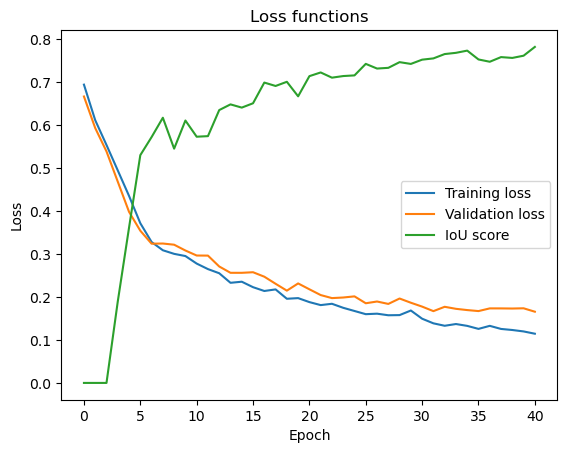


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.7666124077070328
- Loss=0.16573699137994222
Hyperparameters [2/16]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.7112 - VL_loss=0.6948 - IoU=0.3000
Epoch 2/150: TR_loss=0.6733 - VL_loss=0.6453 - IoU=0.0000
Epoch 3/150: TR_loss=0.6072 - VL_loss=0.6031 - IoU=0.0000
Epoch 4/150: TR_loss=0.5772 - VL_loss=0.5821 - IoU=0.0000
Epoch 5/150: TR_loss=0.5555 - VL_loss=0.5664 - IoU=0.0000
Epoch 6/150: TR_loss=0.5350 - VL_loss=0.5418 - IoU=0.0000
Epoch 7/150: TR_loss=0.5067 - VL_loss=0.4915 - IoU=0.0008
Epoch 8/150: TR_loss=0.4420 - VL_loss=0.4330 - IoU=0.3339
Epoch 9/150: TR_loss=0.3952 - VL_loss=0.4008 - IoU=0.3537
Epoch 10/150: TR_loss=0.3649 - VL_loss=0

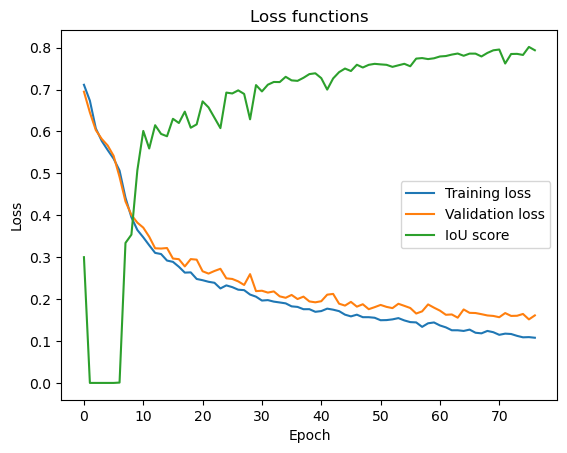


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.7925464312235514
- Loss=0.16110918670892715
Hyperparameters [3/16]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6255 - VL_loss=0.5620 - IoU=0.0000
Epoch 2/150: TR_loss=0.5031 - VL_loss=0.4743 - IoU=0.0008
Epoch 3/150: TR_loss=0.4531 - VL_loss=0.4427 - IoU=0.3924
Epoch 4/150: TR_loss=0.4445 - VL_loss=0.4230 - IoU=0.4666
Epoch 5/150: TR_loss=0.4255 - VL_loss=0.4347 - IoU=0.2425
Epoch 6/150: TR_loss=0.4106 - VL_loss=0.4416 - IoU=0.3964
Epoch 7/150: TR_loss=0.4215 - VL_loss=0.4281 - IoU=0.3234
Epoch 8/150: TR_loss=0.3634 - VL_loss=0.5559 - IoU=0.5358
Epoch 9/150: TR_loss=0.3594 - VL_loss=0.3940 - IoU=0.4962
Epoch 10/150: TR_loss=0.3126 - VL_loss=0.

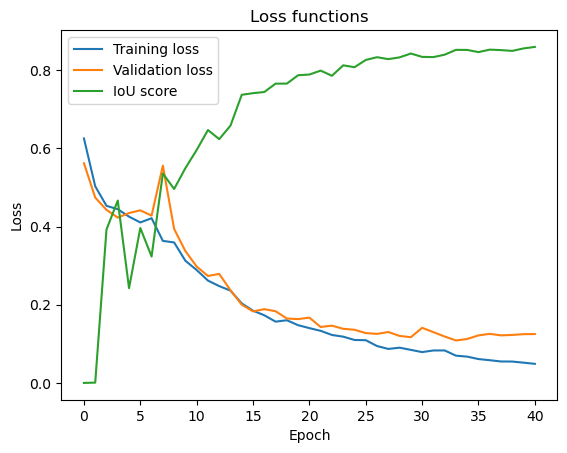


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8550275308745249
- Loss=0.12506110753331864
Hyperparameters [4/16]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6303 - VL_loss=0.5768 - IoU=0.0000
Epoch 2/150: TR_loss=0.5314 - VL_loss=0.4986 - IoU=0.0000
Epoch 3/150: TR_loss=0.4584 - VL_loss=0.4251 - IoU=0.4661
Epoch 4/150: TR_loss=0.4285 - VL_loss=0.4532 - IoU=0.4978
Epoch 5/150: TR_loss=0.5294 - VL_loss=0.4433 - IoU=0.2334
Epoch 6/150: TR_loss=0.4487 - VL_loss=0.4001 - IoU=0.4586
Epoch 7/150: TR_loss=0.4084 - VL_loss=0.4047 - IoU=0.4412
Epoch 8/150: TR_loss=0.3645 - VL_loss=0.3466 - IoU=0.5243
Epoch 9/150: TR_loss=0.3410 - VL_loss=0.3285 - IoU=0.5598
Epoch 10/150: TR_loss=0.3188 - VL_loss=0.3

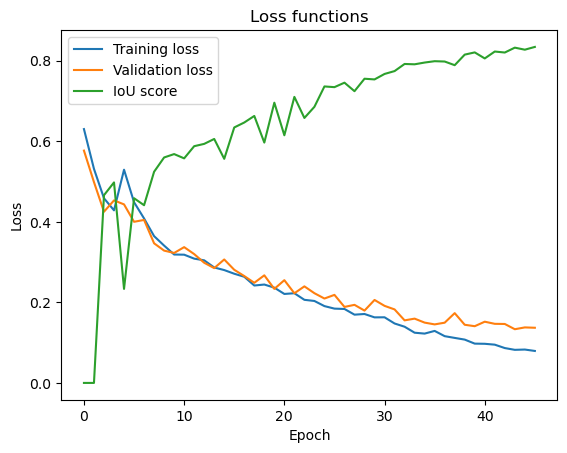


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8550275308745249
- Loss=0.12506110753331864
Hyperparameters [5/16]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6302 - VL_loss=0.5736 - IoU=0.0000
Epoch 2/150: TR_loss=0.5381 - VL_loss=0.5138 - IoU=0.1638
Epoch 3/150: TR_loss=0.4619 - VL_loss=0.4286 - IoU=0.4666
Epoch 4/150: TR_loss=0.3815 - VL_loss=0.3598 - IoU=0.5253
Epoch 5/150: TR_loss=0.3129 - VL_loss=0.3012 - IoU=0.5935
Epoch 6/150: TR_loss=0.2780 - VL_loss=0.2871 - IoU=0.6097
Epoch 7/150: TR_loss=0.2550 - VL_loss=0.2762 - IoU=0.5919
Epoch 8/150: TR_loss=0.2475 - VL_loss=0.2525 - IoU=0.6618
Epoch 9/150: TR_loss=0.2287 - VL_loss=0.2374 - IoU=0.6922
Epoch 10/150: TR_loss=0.2229 - VL_loss=0.2

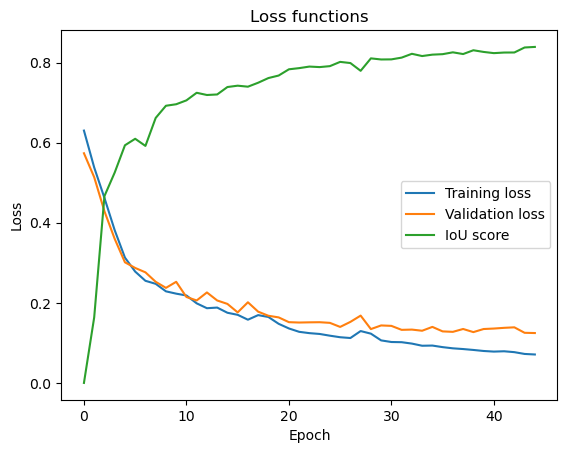


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8550275308745249
- Loss=0.12506110753331864
Hyperparameters [6/16]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.6116 - VL_loss=0.5973 - IoU=0.0000
Epoch 2/150: TR_loss=0.5628 - VL_loss=0.5658 - IoU=0.0000
Epoch 3/150: TR_loss=0.5371 - VL_loss=0.5287 - IoU=0.0000
Epoch 4/150: TR_loss=0.4669 - VL_loss=0.4385 - IoU=0.0000
Epoch 5/150: TR_loss=0.3912 - VL_loss=0.3954 - IoU=0.0000
Epoch 6/150: TR_loss=0.3613 - VL_loss=0.3907 - IoU=0.0796
Epoch 7/150: TR_loss=0.3400 - VL_loss=0.3639 - IoU=0.5974
Epoch 8/150: TR_loss=0.3070 - VL_loss=0.4208 - IoU=0.4223
Epoch 9/150: TR_loss=0.2921 - VL_loss=0.2931 - IoU=0.6482
Epoch 10/150: TR_loss=0.2843 - VL_loss=0.

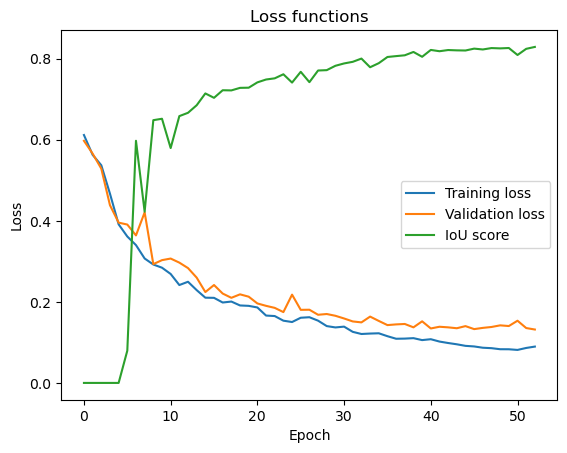


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128]}
- IoU score=0.8550275308745249
- Loss=0.12506110753331864
Hyperparameters [7/16]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.5414 - VL_loss=0.6504 - IoU=0.0000
Epoch 2/150: TR_loss=0.4597 - VL_loss=0.4142 - IoU=0.3871
Epoch 3/150: TR_loss=0.3856 - VL_loss=0.3706 - IoU=0.2097
Epoch 4/150: TR_loss=0.3350 - VL_loss=0.3530 - IoU=0.5659
Epoch 5/150: TR_loss=0.3269 - VL_loss=0.3189 - IoU=0.6151
Epoch 6/150: TR_loss=0.3008 - VL_loss=0.3360 - IoU=0.5806
Epoch 7/150: TR_loss=0.2707 - VL_loss=0.3718 - IoU=0.6246
Epoch 8/150: TR_loss=0.2416 - VL_loss=0.2675 - IoU=0.6336
Epoch 9/150: TR_loss=0.2097 - VL_loss=0.2343 - IoU=0.7134
Epoch 10/150: TR_loss=0.1909 - VL_loss=0.19

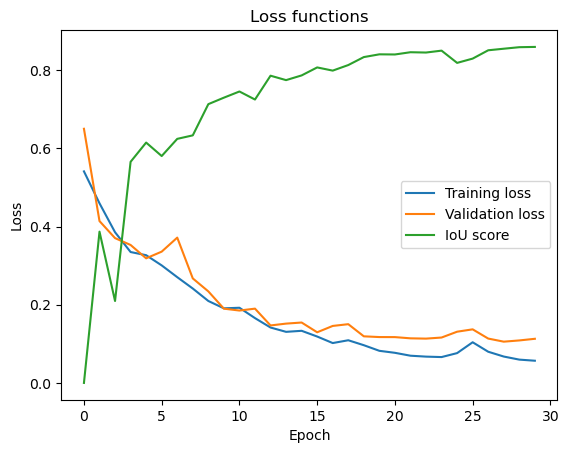


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8580950867562067
- Loss=0.11296161264181137
Hyperparameters [8/16]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
Epoch 1/150: TR_loss=0.7659 - VL_loss=0.6170 - IoU=0.2380
Epoch 2/150: TR_loss=0.5905 - VL_loss=0.5676 - IoU=0.0000
Epoch 3/150: TR_loss=0.5137 - VL_loss=0.4653 - IoU=0.0000
Epoch 4/150: TR_loss=0.4053 - VL_loss=0.4228 - IoU=0.4966
Epoch 5/150: TR_loss=0.3766 - VL_loss=0.4093 - IoU=0.5344
Epoch 6/150: TR_loss=0.3603 - VL_loss=0.3709 - IoU=0.5566
Epoch 7/150: TR_loss=0.3102 - VL_loss=0.3635 - IoU=0.4784
Epoch 8/150: TR_loss=0.2638 - VL_loss=0.2996 - IoU=0.6012
Epoch 9/150: TR_loss=0.2554 - VL_loss=0.3337 - IoU=0.5404
Epoch 10/150: TR_loss=0.2365 - VL_loss=0.2

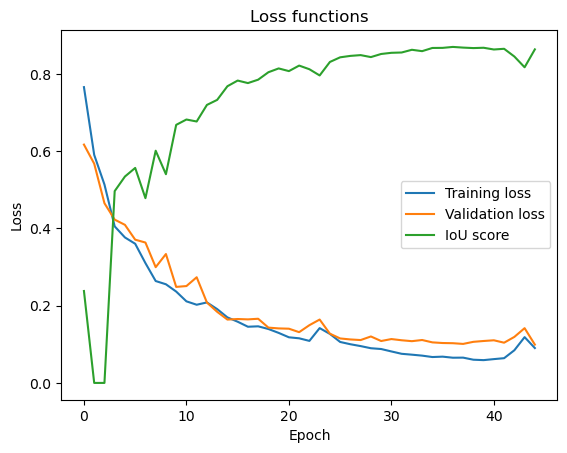


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8580950867562067
- Loss=0.11296161264181137
Hyperparameters [9/16]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6456 - VL_loss=0.6302 - IoU=0.0000
Epoch 2/150: TR_loss=0.5846 - VL_loss=0.5642 - IoU=0.0000
Epoch 3/150: TR_loss=0.5063 - VL_loss=0.4552 - IoU=0.0000
Epoch 4/150: TR_loss=0.4127 - VL_loss=0.4087 - IoU=0.4198
Epoch 5/150: TR_loss=0.3620 - VL_loss=0.3606 - IoU=0.5452
Epoch 6/150: TR_loss=0.3309 - VL_loss=0.3350 - IoU=0.5749
Epoch 7/150: TR_loss=0.2996 - VL_loss=0.3129 - IoU=0.5985
Epoch 8/150: TR_loss=0.2922 - VL_loss=0.3213 - IoU=0.6264
Epoch 9/150: TR_loss=0.2758 - VL_loss=0.2738 - IoU=0.6486
Epoch 10/150: TR_loss=0.2556 - VL_los

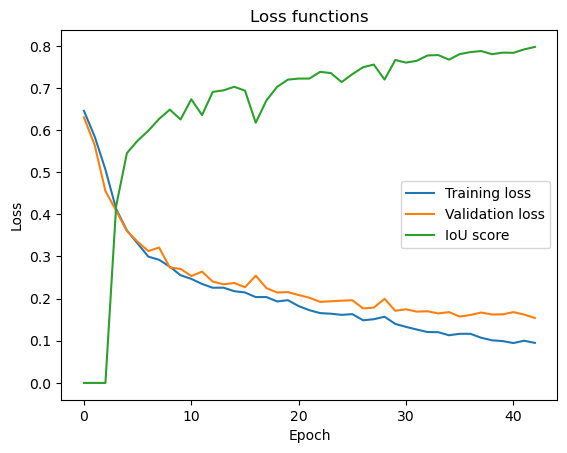


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8580950867562067
- Loss=0.11296161264181137
Hyperparameters [10/16]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.7312 - VL_loss=0.7237 - IoU=0.2776
Epoch 2/150: TR_loss=0.7113 - VL_loss=0.6957 - IoU=0.0076
Epoch 3/150: TR_loss=0.6448 - VL_loss=0.6501 - IoU=0.0000
Epoch 4/150: TR_loss=0.5995 - VL_loss=0.5989 - IoU=0.0000
Epoch 5/150: TR_loss=0.5469 - VL_loss=0.5087 - IoU=0.0000
Epoch 6/150: TR_loss=0.4458 - VL_loss=0.4649 - IoU=0.2615
Epoch 7/150: TR_loss=0.4160 - VL_loss=0.4434 - IoU=0.4356
Epoch 8/150: TR_loss=0.4055 - VL_loss=0.4212 - IoU=0.4849
Epoch 9/150: TR_loss=0.3895 - VL_loss=0.3930 - IoU=0.5009
Epoch 10/150: TR_loss=0.3685 - VL_l

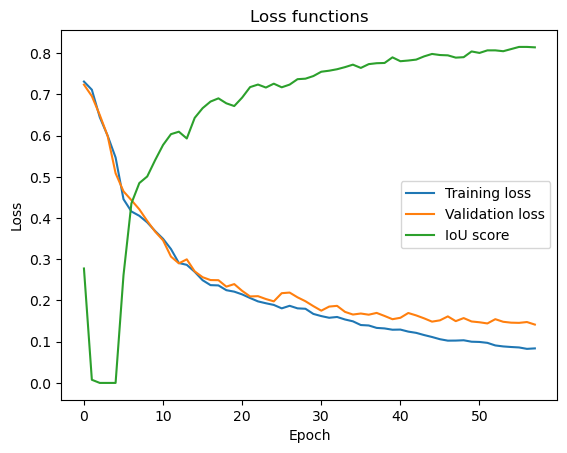


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8580950867562067
- Loss=0.11296161264181137
Hyperparameters [11/16]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.5372 - VL_loss=0.4824 - IoU=0.2695
Epoch 2/150: TR_loss=0.4409 - VL_loss=0.4236 - IoU=0.4614
Epoch 3/150: TR_loss=0.4144 - VL_loss=0.3943 - IoU=0.4629
Epoch 4/150: TR_loss=0.4093 - VL_loss=0.4091 - IoU=0.4616
Epoch 5/150: TR_loss=0.4037 - VL_loss=0.3987 - IoU=0.4854
Epoch 6/150: TR_loss=0.4003 - VL_loss=0.4075 - IoU=0.4896
Epoch 7/150: TR_loss=0.3896 - VL_loss=0.4231 - IoU=0.2435
Epoch 8/150: TR_loss=0.3987 - VL_loss=0.3928 - IoU=0.4268
Epoch 9/150: TR_loss=0.3867 - VL_loss=0.4354 - IoU=0.4951
Epoch 10/150: TR_loss=0.3446 - VL_los

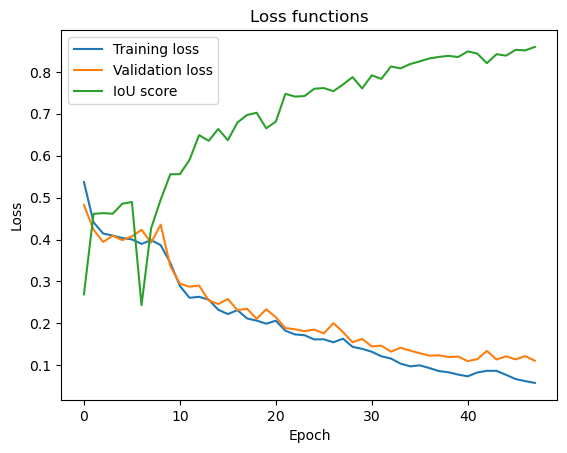


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8580950867562067
- Loss=0.11296161264181137
Hyperparameters [12/16]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 3, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.5768 - VL_loss=0.5074 - IoU=0.1887
Epoch 2/150: TR_loss=0.4608 - VL_loss=0.4263 - IoU=0.5068
Epoch 3/150: TR_loss=0.4369 - VL_loss=0.4685 - IoU=0.4610
Epoch 4/150: TR_loss=0.4372 - VL_loss=0.4257 - IoU=0.5152
Epoch 5/150: TR_loss=0.4122 - VL_loss=0.4157 - IoU=0.5150
Epoch 6/150: TR_loss=0.3993 - VL_loss=0.4632 - IoU=0.2989
Epoch 7/150: TR_loss=0.4044 - VL_loss=0.4058 - IoU=0.4518
Epoch 8/150: TR_loss=0.3802 - VL_loss=0.4242 - IoU=0.2536
Epoch 9/150: TR_loss=0.3710 - VL_loss=0.3978 - IoU=0.4675
Epoch 10/150: TR_loss=0.3828 - VL_lo

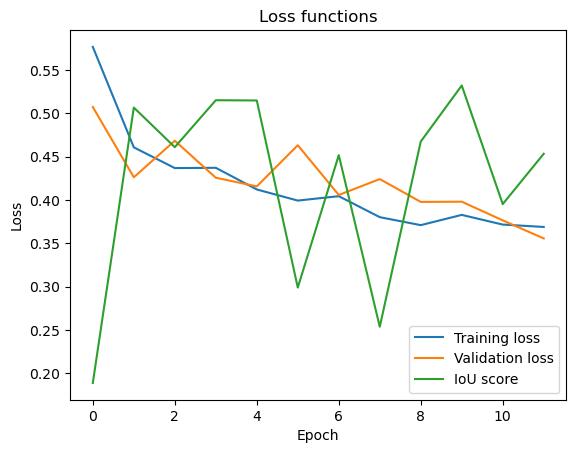


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8580950867562067
- Loss=0.11296161264181137
Hyperparameters [13/16]: {'batch_size': 8, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6361 - VL_loss=0.5884 - IoU=0.0000
Epoch 2/150: TR_loss=0.5509 - VL_loss=0.5266 - IoU=0.0255
Epoch 3/150: TR_loss=0.4558 - VL_loss=0.4270 - IoU=0.4689
Epoch 4/150: TR_loss=0.3643 - VL_loss=0.3500 - IoU=0.5880
Epoch 5/150: TR_loss=0.3141 - VL_loss=0.3225 - IoU=0.6045
Epoch 6/150: TR_loss=0.2836 - VL_loss=0.2938 - IoU=0.6214
Epoch 7/150: TR_loss=0.2726 - VL_loss=0.2888 - IoU=0.6193
Epoch 8/150: TR_loss=0.2653 - VL_loss=0.2738 - IoU=0.6536
Epoch 9/150: TR_loss=0.2571 - VL_loss=0.2841 - IoU=0.6584
Epoch 10/150: TR_loss=0.2452 - VL_lo

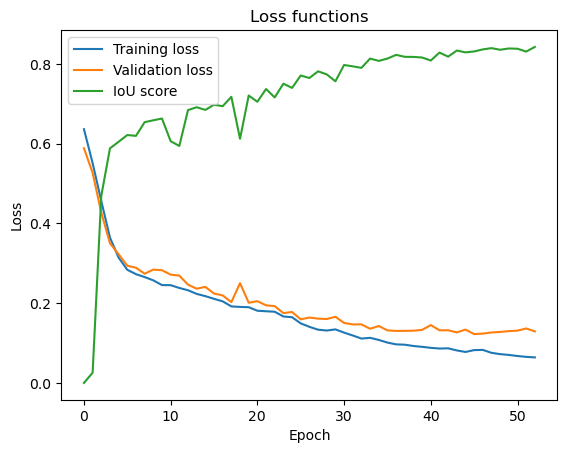


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8580950867562067
- Loss=0.11296161264181137
Hyperparameters [14/16]: {'batch_size': 16, 'learning_rate': 0.0001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6387 - VL_loss=0.6223 - IoU=0.0000
Epoch 2/150: TR_loss=0.5693 - VL_loss=0.5646 - IoU=0.0000
Epoch 3/150: TR_loss=0.5086 - VL_loss=0.4976 - IoU=0.0000
Epoch 4/150: TR_loss=0.4245 - VL_loss=0.4239 - IoU=0.5446
Epoch 5/150: TR_loss=0.3677 - VL_loss=0.3666 - IoU=0.6172
Epoch 6/150: TR_loss=0.3271 - VL_loss=0.3539 - IoU=0.5905
Epoch 7/150: TR_loss=0.3091 - VL_loss=0.2960 - IoU=0.6523
Epoch 8/150: TR_loss=0.2723 - VL_loss=0.2761 - IoU=0.6550
Epoch 9/150: TR_loss=0.2614 - VL_loss=0.2671 - IoU=0.6347
Epoch 10/150: TR_loss=0.2596 - VL_l

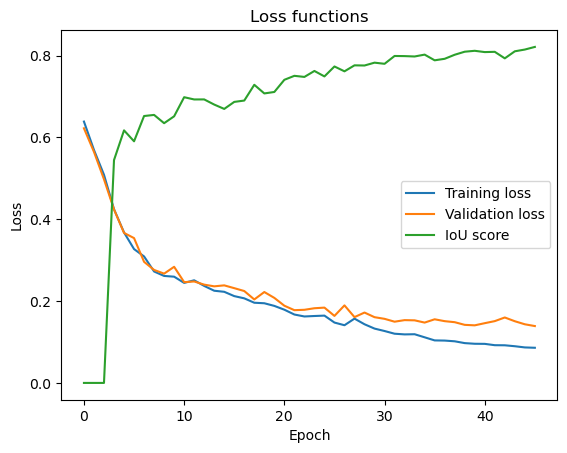


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8580950867562067
- Loss=0.11296161264181137
Hyperparameters [15/16]: {'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.6401 - VL_loss=0.5815 - IoU=0.0000
Epoch 2/150: TR_loss=0.4833 - VL_loss=0.4542 - IoU=0.0459
Epoch 3/150: TR_loss=0.4209 - VL_loss=0.3677 - IoU=0.4918
Epoch 4/150: TR_loss=0.3175 - VL_loss=0.3453 - IoU=0.6000
Epoch 5/150: TR_loss=0.2986 - VL_loss=0.2874 - IoU=0.5733
Epoch 6/150: TR_loss=0.2563 - VL_loss=0.2705 - IoU=0.6561
Epoch 7/150: TR_loss=0.2410 - VL_loss=0.2505 - IoU=0.6598
Epoch 8/150: TR_loss=0.2336 - VL_loss=0.2393 - IoU=0.6769
Epoch 9/150: TR_loss=0.2139 - VL_loss=0.2145 - IoU=0.6860
Epoch 10/150: TR_loss=0.2080 - VL_los

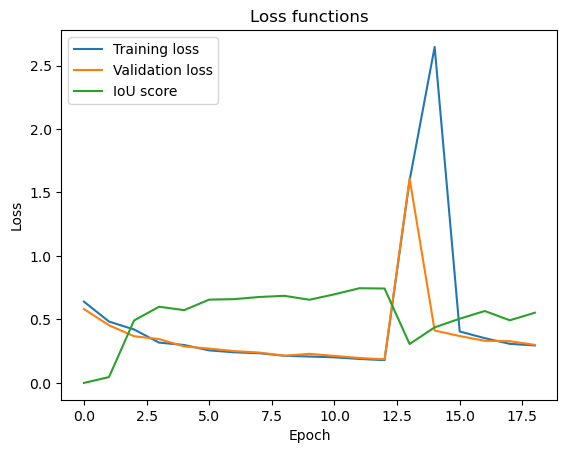


Best model:
- Hyperparameters={'batch_size': 8, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128]}
- IoU score=0.8580950867562067
- Loss=0.11296161264181137
Hyperparameters [16/16]: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Epoch 1/150: TR_loss=0.5850 - VL_loss=0.5540 - IoU=0.0000
Epoch 2/150: TR_loss=0.4931 - VL_loss=0.4839 - IoU=0.4723
Epoch 3/150: TR_loss=0.4346 - VL_loss=0.4487 - IoU=0.2269
Epoch 4/150: TR_loss=0.4335 - VL_loss=0.3932 - IoU=0.4034
Epoch 5/150: TR_loss=0.4050 - VL_loss=0.4696 - IoU=0.5061
Epoch 6/150: TR_loss=0.4232 - VL_loss=0.4405 - IoU=0.5495
Epoch 7/150: TR_loss=0.3436 - VL_loss=0.3400 - IoU=0.6283
Epoch 8/150: TR_loss=0.3036 - VL_loss=0.3206 - IoU=0.6356
Epoch 9/150: TR_loss=0.2916 - VL_loss=0.2942 - IoU=0.6709
Epoch 10/150: TR_loss=0.2763 - VL_lo

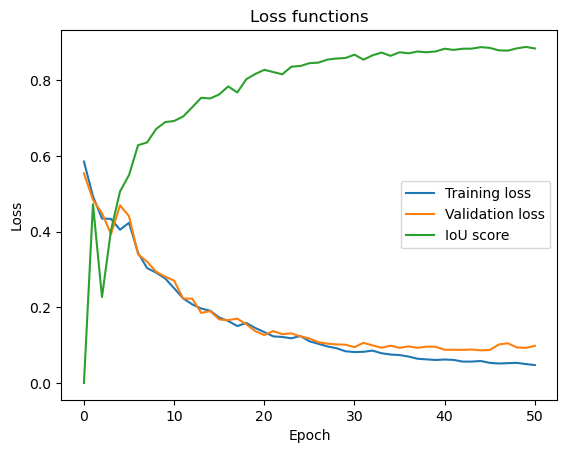


Best model:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
- IoU score=0.8854090968767802
- Loss=0.09796013031154871


Model selection result:
- Hyperparameters={'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
- IoU score=0.8854090968767802
- Loss=0.09796013031154871


In [379]:
def get_params_combinations(params: dict) -> list[dict]:
    '''
    Creates and saves into the class instance a list with all the possible combinations of parameters \
    in the dictionary "params".

    Parameters:
    - params: dictionary with the parameters as associations <key:values> (with: key=parameter_name,
    values=possible_values_list).

    Returns:
    A list of dictionaries such that each one represents a combination of parameters (1 combination = 1 dictionary).
    '''
    params_index_dict = {}
    params_combinations = []
    for key in params.keys():
        params_index_dict[key] = 0 # current_index for that key
    while sum([index+1 for _, index in params_index_dict.items()]) != sum(len(val_list) for _, val_list in params.items()):
        params_i = {}
        for key, i in params_index_dict.items():
            params_i[key] = params[key][i]
        params_combinations.append(params_i)
        for key in params_index_dict.keys():
            params_index_dict[key] += 1
            if params_index_dict[key] < len(params[key]):
                break
            params_index_dict[key] = 0
    params_i = {}
    for key, i in params_index_dict.items():
        params_i[key] = params[key][i]
    params_combinations.append(params_i)
    return params_combinations


def show_plots(values_list: list[list], labels: list[str]):
    '''
    Shows the plots of the values in the list "values_list". Each list in "values_list" is plotted with
    the corresponding label in "labels".

    Parameters:
    - values_list: list of lists with the values to plot.
    - labels: list of labels for each plot.
    '''
    for i, values in enumerate(values_list):
        plt.plot(values, label=labels[i])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss functions')
    plt.show()


# Iterates on each parameters combination obtained from the parameters space
tr_dataset, vl_dataset, ts_dataset = random_split(horse_dataset, [0.70,0.15,0.15])
params_list = get_params_combinations(params_space)
model_i = None
best_model_obj = {'iou_scores': [0]}
for i, params in enumerate(params_list):
    print(f'Hyperparameters [{i+1}/{len(params_list)}]: {params}')

    # Datasets initializations
    tr_loader = DataLoader(tr_dataset, batch_size=params['batch_size'], shuffle=True)
    vl_loader = DataLoader(vl_dataset, batch_size=params['batch_size'], shuffle=False)

    # Create the model
    #model = ConvolutionalAE(**params['architecture'])
    model = UNet(kernel_size=params['kernel_size'], features=params['features'], activation=params['activation'])
    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = torch.nn.BCELoss()

    # Training phase
    tr_losses, vl_losses, iou_scores = train(
        model,
        tr_dataloader=tr_loader,
        vl_dataloader=vl_loader,
        optimizer=optimizer,
        criterion=criterion,
        device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
        epochs=params['epochs'],
        threshold=params['threshold'],
        tolerance=params['tolerance'],
        verbose=2
    )

    # Save the model and the parameters
    model_i = {
        'model': model,
        'params': params,
        'tr_losses': tr_losses,
        'vl_losses': vl_losses,
        'iou_scores': iou_scores
    }

    # Shows the Loss plots
    show_plots(
        values_list=[tr_losses,vl_losses,iou_scores],
        labels=['Training loss','Validation loss','IoU score']
    )

    # Save the model if is the best one (based on the highest mean of the last 3 IoU score)
    mean_iou_best_score = np.mean(best_model_obj['iou_scores'][-3:])
    mean_iou_score = np.mean(iou_scores[-3:])
    if mean_iou_best_score < mean_iou_score:
        best_model_obj = model_i
    print(f'\nBest model:\n- Hyperparameters={best_model_obj["params"]}\n- IoU score={np.mean(best_model_obj["iou_scores"][-3:])}\n- Loss={best_model_obj["vl_losses"][-1]}')

# Print of the best model
print(f'\n\nModel selection result:\n- Hyperparameters={best_model_obj["params"]}\n- IoU score={np.mean(best_model_obj["iou_scores"][-3:])}\n- Loss={best_model_obj["vl_losses"][-1]}')

## Model evaluation

The following code evaluates the best model chosen in the Model selection.

The "evaluate" method shows the predicted masks for the first images (10 by default) of the Test set and returns the average of the IoU score and the average of the loss.

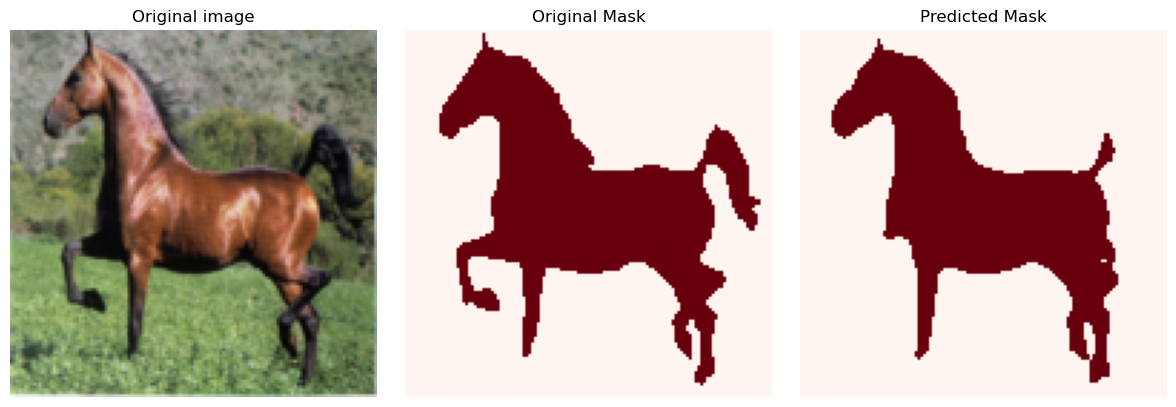

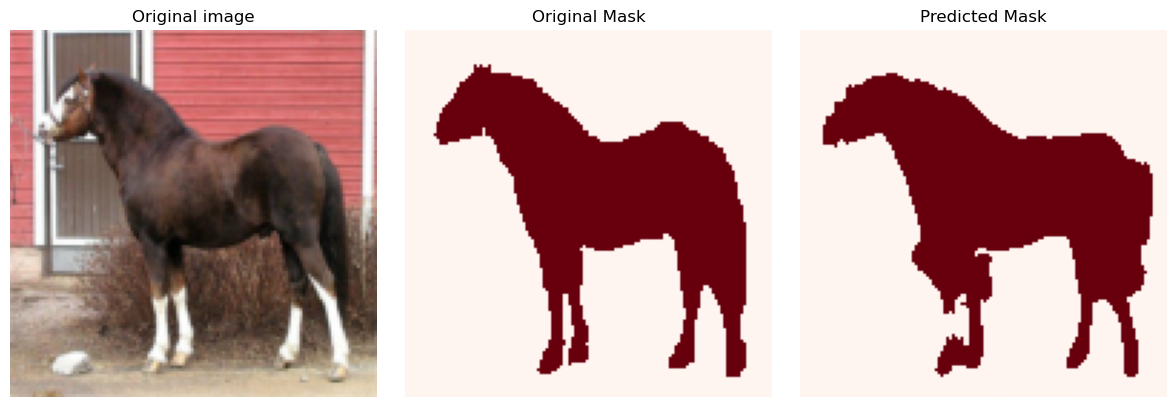

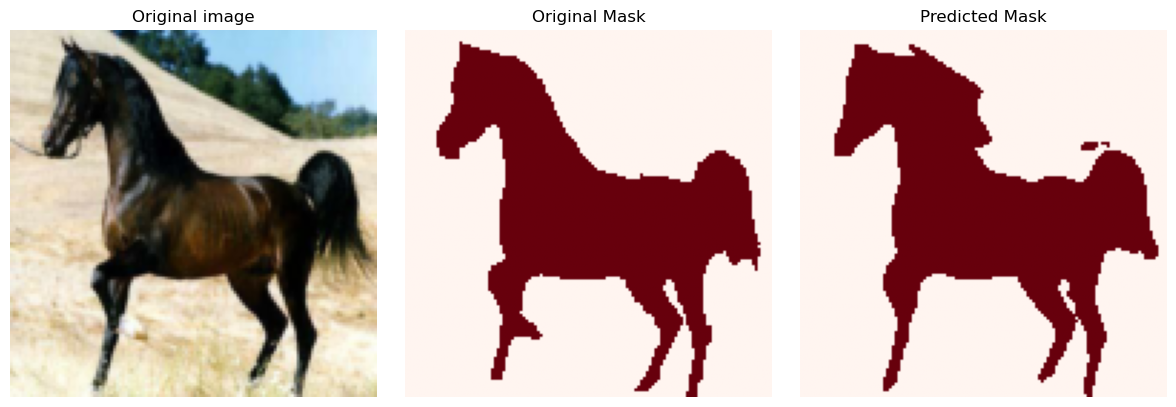

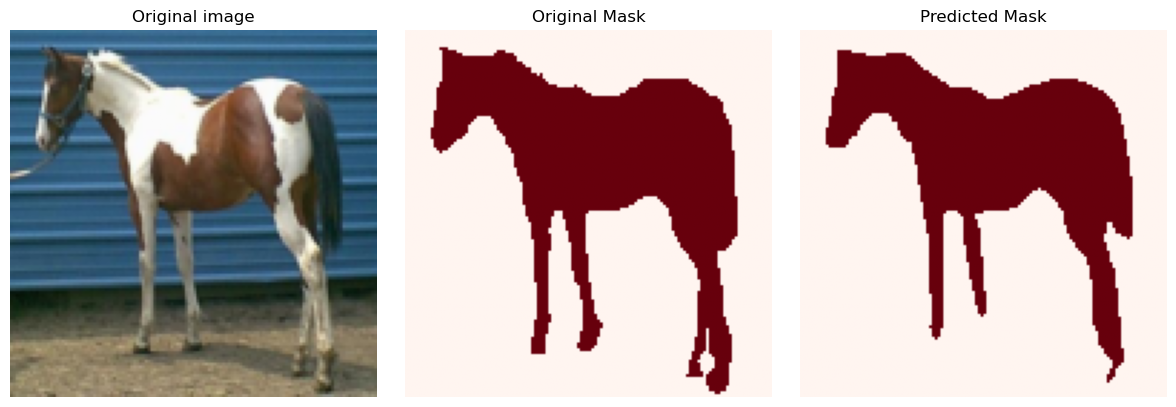

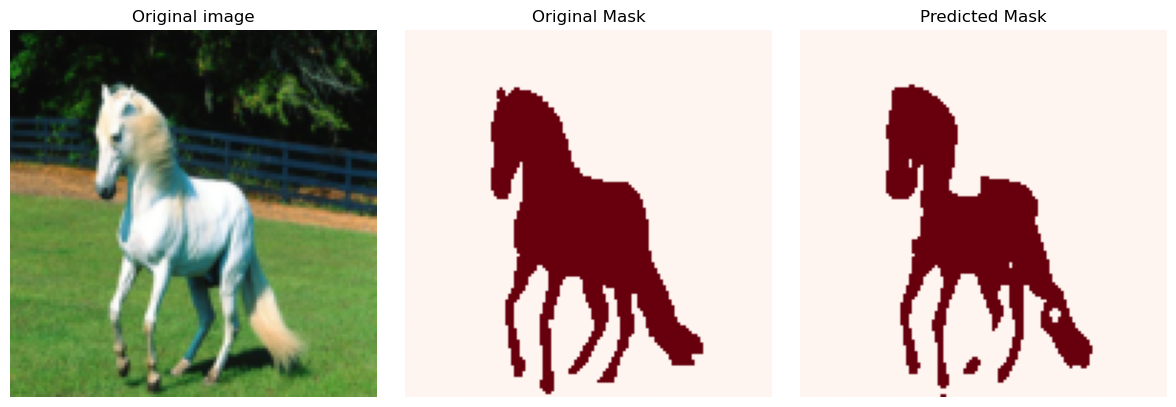

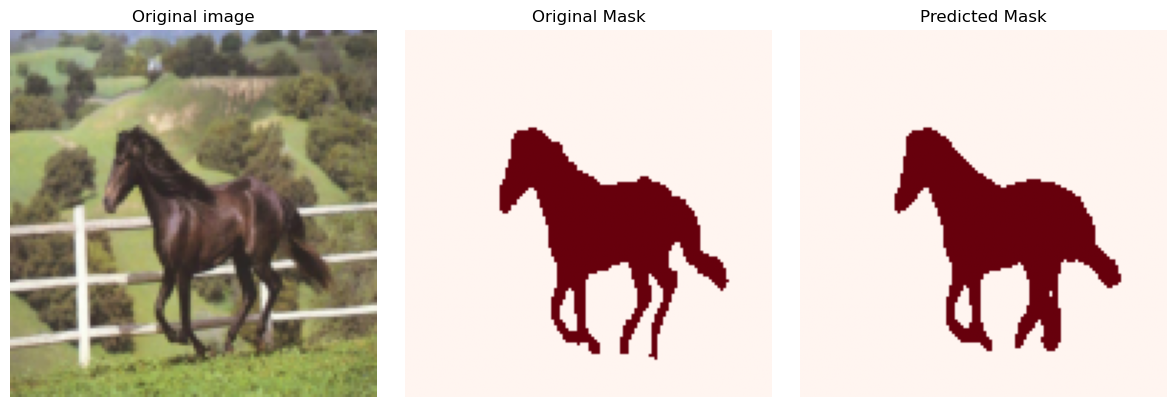

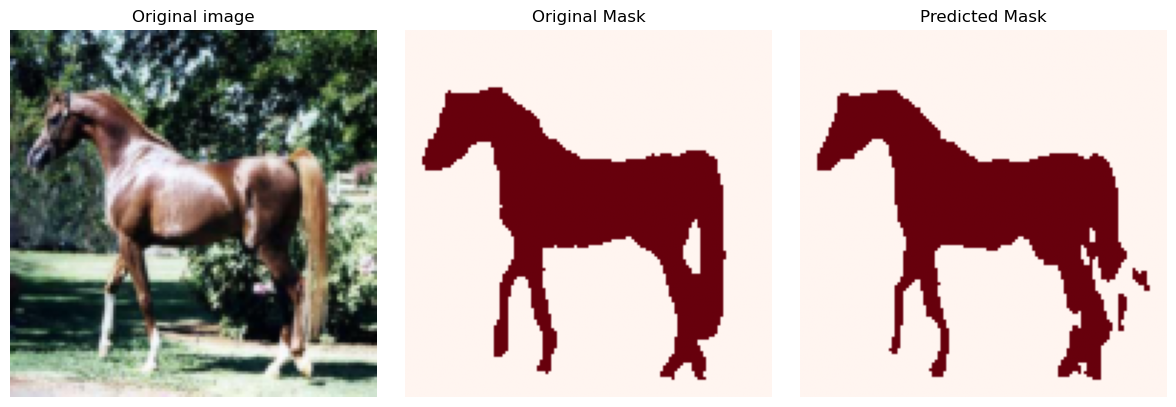

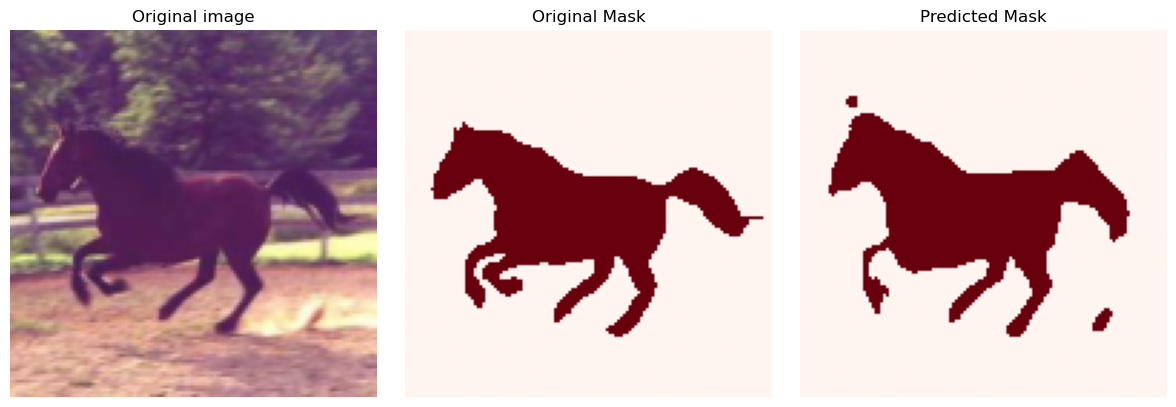

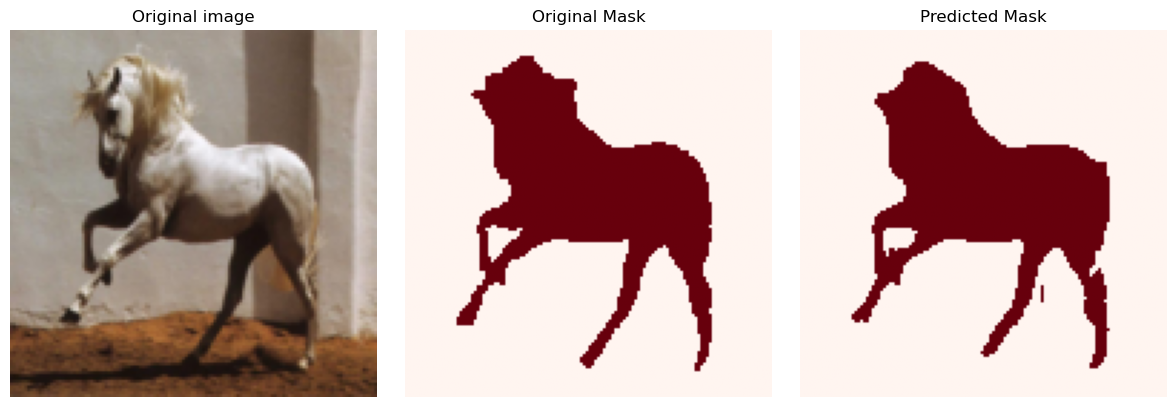

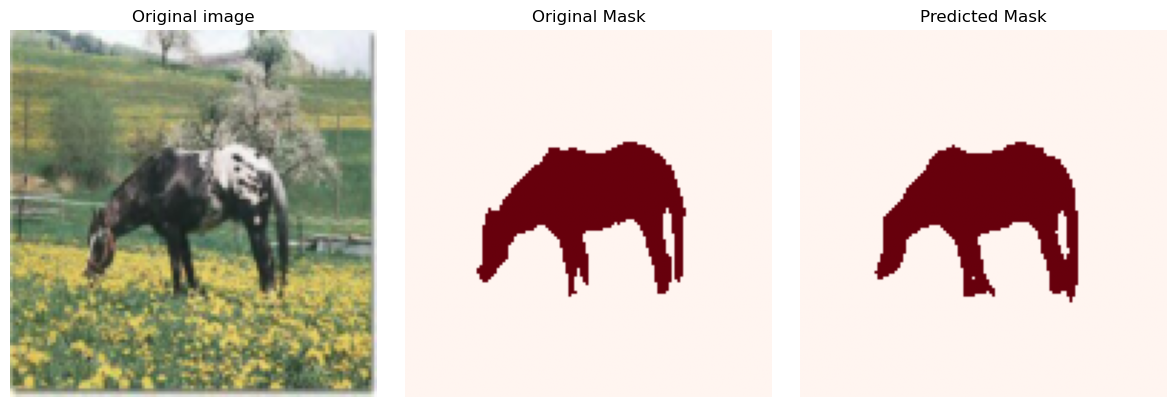

Best model parameters: {'batch_size': 16, 'learning_rate': 0.001, 'epochs': 150, 'threshold': 0.0005, 'tolerance': 5, 'activation': 'relu', 'kernel_size': 5, 'features': [32, 64, 128, 256]}
Test Loss: 0.23818765580654144
Test IoU score: 0.7995280772447586


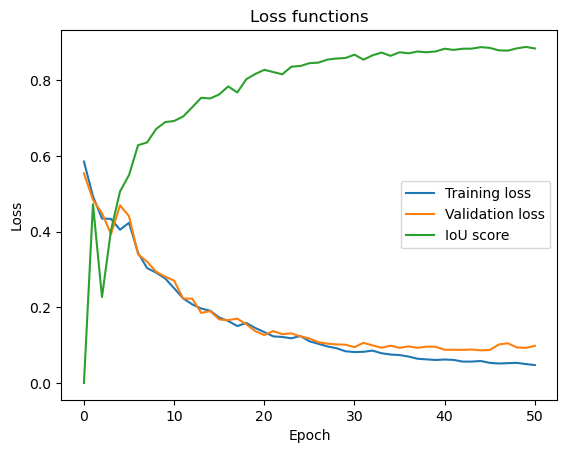

In [380]:
def show_prediction_plot(img: torch.Tensor, mask: torch.Tensor, pred: torch.Tensor):
    '''
    Shows the original image, the original mask and the predicted mask passed as parameters.

    Parameters:
    - img (torch.Tensor): the original image.
    - mask (torch.Tensor): the original mask.
    - pred (torch.Tensor): the predicted mask.
    '''
    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img)
    axs[0].set_title('Original image')
    axs[0].axis('off')
    axs[1].imshow(mask, cmap='Reds')
    axs[1].set_title('Original Mask')
    axs[1].axis('off')
    axs[2].imshow(pred, cmap='Reds')
    axs[2].set_title('Predicted Mask')
    axs[2].axis('off')
    plt.tight_layout()
    plt.show()



def denormalize(img: torch.Tensor, dataset: Dataset) -> torch.Tensor:
    '''
    Denormalizes the image passed as parameter based on the mean and standard deviation of the dataset.
    
    Parameters:
    - img (torch.Tensor): the image to denormalize.
    - dataset (Dataset): the dataset of the image from which the mean and std are taken.
    '''
    mean, std = dataset.mean, dataset.std
    for tensor, m, s in zip(img, mean, std):
        tensor.mul_(s).add_(m)
    return img



def evaluate(model: nn.Module, ts_dataloader: DataLoader, criterion, device, n_imgs_to_show=10):
    '''
    Test the model on the test set. The model is evaluated using the IoU score.

    Parameters:
    - model (nn.Module): the model to evaluate.
    - ts_dataloader (DataLoader): the test set.
    - criterion: the loss function to use.
    - device: the device to use (CPU or GPU).
    - n_imgs_to_show: the number of images of which show the predictions.

    Returns:
    - iou_avg_score: the average IoU score.
    - avg_loss: the average loss.
    '''
    model.eval()
    model.to(device)

    # Initializations
    total_loss = 0.0
    total_iou = 0.0
    shown = 0

    with torch.no_grad():
        for imgs, masks in ts_dataloader:
            imgs = imgs.to(device)
            masks = masks.to(device)

            # Compute the predictions and the loss
            preds = model(imgs)
            loss = criterion(preds, masks)
            total_loss += loss.item()

            # Binarization of the predictions
            preds = (preds > 0.5).float()

            # Case of plot of the images
            if shown < n_imgs_to_show:
                # Matplotlib can't handle GPU tensors (so we need to move them to CPU)
                imgs_cpu = imgs.cpu()
                masks_cpu = masks.cpu()
                preds_cpu = preds.cpu()
                # Plot the images
                for img, mask, pred in zip(imgs_cpu, masks_cpu, preds_cpu):
                    mask = (mask > 0.5).float()
                    pred = (pred > 0.5).float()
                    if shown == n_imgs_to_show:
                        break
                    img = denormalize(img, horse_dataset)
                    show_prediction_plot(img.permute(1,2,0), mask[0], pred[0])
                    shown += 1

            # Compute the number of correct pixels predicted
            total_iou += iou(preds, masks)

    # Accuracy and average loss
    iou_avg_score = total_iou / len(ts_dataloader)
    avg_loss = total_loss / len(ts_dataloader)
    return iou_avg_score, avg_loss



# Create the test dataloader
ts_loader = DataLoader(ts_dataset, batch_size=best_model_obj['params']['batch_size'], shuffle=False)

# Evaluation phase
iou_score, avg_loss = evaluate(
    model=best_model_obj['model'],
    ts_dataloader=ts_loader,
    criterion=criterion,
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
)

# Show the results
print(f'Best model parameters: {best_model_obj["params"]}')
print(f'Test Loss: {avg_loss}')
print(f'Test IoU score: {iou_score}')
show_plots(
    values_list=[best_model_obj['tr_losses'], best_model_obj['vl_losses'], best_model_obj['iou_scores']],
    labels=['Training loss', 'Validation loss', 'IoU score']
)

## Conclusions

The U-Net architecture demonstrated strong performance in segmenting horses from the background, achieving a IoU score of 86.49%. The model accurately captures the overall shape of the horse across different poses and backgrounds, although some fine details are missed.

These results confirm the effectiveness of UNets for binary semantic segmentation tasks. The skip connections highlight the importance of recovering details lost during downsampling, a feature that is absent in standard CAE architectures.